In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import nibabel as nib
from time import time
from xml.etree import ElementTree as ET
import os
import pandas as pd
import sys
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
from scipy import signal
from scipy.ndimage import zoom
import smtplib
from email.mime.text import MIMEText
import re
import skimage
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import scipy
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

sys.path.insert(0, '/home/users/brezovec/projects/lysis/')
from bruker import *

sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants

#%matplotlib inline
#%matplotlib notebook

In [3]:
from bigbrain.brain import bleaching_correction
from bigbrain.brain import z_score_brain
from bigbrain.brain import get_resolution
from bigbrain.fictrac import load_fictrac
from bigbrain.fictrac import prep_fictrac
from bigbrain.utils import load_timestamps
from bigbrain.utils import sort_nicely
from bigbrain.utils import send_email
from bigbrain.glm import fit_glm
from bigbrain.glm import save_glm_map
from bigbrain.motcorr import get_motcorr_brain
from bigbrain.brain import load_numpy_brain
from bigbrain.utils import timing

In [67]:
def load_brain(file):
    try:
        brain = nib.load(file).get_data()
        brain = np.swapaxes(brain, 0, 1)
        brain = np.squeeze(brain)
        brain = ants.from_numpy(brain)
    except:
        brain = None
    return brain

def rotate_brain(brain):
    try:
        if type(brain) is not np.ndarray:
            brain = brain.numpy()
        brain = np.swapaxes(brain, 0, 1)
        brain = ants.from_numpy(brain)
    except:
        brain = None
    return brain

def remove_empty_axes(brain):
    if type(brain) is not np.ndarray:
        brain = brain.numpy()
    brain = np.squeeze(brain)
    brain = ants.from_numpy(brain)
    return brain

def load_brains_from_dir(folder):
    brain_files = sorted(os.listdir(folder))
    full_brain_files = [folder+brain_file for brain_file in brain_files]
    brains = [load_brain(brain) for brain in full_brain_files]
    return brains

def set_resolution(brain, xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    statevalues = root.findall('PVStateShard')[0].findall('PVStateValue')
    for statevalue in statevalues:
        key = statevalue.get('key')
        if key == 'micronsPerPixel':
            indices = statevalue.findall('IndexedValue')
            for index in indices:
                axis = index.get('index')
                if axis == 'XAxis':
                    x = float(index.get('value'))
                elif axis == 'YAxis':
                    y = float(index.get('value'))
                elif axis == 'ZAxis':
                    z = float(index.get('value'))
                else:
                    print('Error')
    try:
        brain.set_spacing([x,y,z])
    except:
        print('Failed')
        
def get_resolution(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    statevalues = root.findall('PVStateShard')[0].findall('PVStateValue')
    for statevalue in statevalues:
        key = statevalue.get('key')
        if key == 'micronsPerPixel':
            indices = statevalue.findall('IndexedValue')
            for index in indices:
                axis = index.get('index')
                if axis == 'XAxis':
                    x = float(index.get('value'))
                elif axis == 'YAxis':
                    y = float(index.get('value'))
                elif axis == 'ZAxis':
                    z = float(index.get('value'))
                else:
                    print('Error')
    return x, y, z

def send_email(subject='', message=''):
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login("python.notific@gmail.com", "9!tTT77x!ma8cGy")

    msg = MIMEText(message)
    msg['Subject'] = subject

    to = "brezovec@stanford.edu"
    server.sendmail(to, to, msg.as_string())
    server.quit()
    
    
def alphanum_key(s):
    return [tryint(c) for c in re.split('([0-9]+)', s)]

def sort_nicely(x):
    x.sort(key=alphanum_key)
    
def tryint(s):
    try:
        return int(s)
    except:
        return s
    
def create_grid(x_dim, y_dim, z_dim, spacing = 5):
    xyz = np.zeros((x_dim, y_dim, z_dim))
    idx_x = np.arange(0,x_dim,spacing)
    idx_y = np.arange(0,y_dim,spacing)
    idx_z = np.arange(0,z_dim,spacing)

    for z in range(z_dim):
        # if on a idx_z, then puts 1s where idx_x or idx_y are true
        if z in idx_z:
            xyz[idx_x,:,z] = 1
            xyz[:,idx_y,z] = 1
        # if not on a idx_z, then put 1s where idx_x AND idx_y are true
        else:
            for x in idx_x:
                for y in idx_y: 
                    xyz[x,y,z] = 1

    #xyz = np.swapaxes(xyz, 0, 1)
    return xyz

def create_node_grid(x_dim, y_dim, z_dim, spacing = 5):
    xyz = np.zeros((x_dim, y_dim, z_dim))
    idx_x = np.arange(0,x_dim,spacing)
    idx_y = np.arange(0,y_dim,spacing)
    idx_z = np.arange(0,z_dim,spacing)

    for z in idx_z:
        for x in idx_x:
            for y in idx_y: 
                xyz[x,y,z] = 1

    #xyz = np.swapaxes(xyz, 0, 1)
    return xyz

def grid_to_vectors(grid, x_dim, y_dim, z_dim):
    X=[]; Y=[]; Z=[]
    for x in range(x_dim):
        for y in range(y_dim):
            for z in range(z_dim):
                if grid[x,y,z] > 0:
                    X.append(x)
                    Y.append(y)
                    Z.append(z)
    return X,Y,Z

def set_axes_radius(ax, origin, radius):
    ax.set_xlim3d([origin[0] - radius, origin[0] + radius])
    ax.set_ylim3d([origin[1] - radius, origin[1] + radius])
    ax.set_zlim3d([origin[2] - radius, origin[2] + radius])

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])

    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    set_axes_radius(ax, origin, radius)
    
def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube):
    cube = normalize(cube)

    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)

    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))
    return x,y,z,filled,facecolors

In [3]:
def load_numpy_brain(file, channel=None, flip=False):
    # If no channel specified, load all channels, else load specified channel
    brain = nib.load(file).get_data()
    if channel == 'red':
        brain = brain[:,:,:,:,0] # for red brain.
    if channel  == 'green':
        brain = brain[:,:,:,:,1] # for green brain.
    #brain = np.swapaxes(brain, 0, 1)
    if flip is True:
        brain = np.flip(brain, 2)
    brain = np.squeeze(brain)
    brain = np.asarray(brain, 'float64')
    #brain = ants.from_numpy(brain)
    return brain

In [4]:
class Surface:
    def __init__(self, verts, faces, normals, values):
        self.verts = verts
        self.faces = faces
        self.normals = normals
        self.values = values 

def make_brain_surface(brain, thresh=None, sigma=None, scale=None):
    if scale is not None:
        brain = rescale_brain(brain, scale)
    if sigma is not None:
        brain = scipy.ndimage.filters.gaussian_filter(brain, sigma=sigma)
    # switch z and y, and then flip z
    brain = np.swapaxes(brain, 1, 2)
    brain = np.flip(brain, -1)
    if thresh is None:
        thresh = skimage.filters.threshold_triangle(brain, nbins=256)
    verts, faces, normals, values = measure.marching_cubes_lewiner(brain, thresh)
    # package variables
    surface = Surface(verts, faces, normals, values)
    return surface

def rescale_brain(brain, scale=4):
    brain_down = ants.resample_image(ants.from_numpy(brain),
                (int(brain.shape[0]/scale),
                 int(brain.shape[1]/scale),
                 int(brain.shape[2]/scale)),
                 use_voxels=True).numpy()
    return brain_down

In [5]:
def plot_surfaces(surfaces, elev=0, azim=90, save=False, frame=None, folder=None):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    edgecolors = ['#667896FF', '#f4426e80']
    facecolors = ['#1f77b400', '#f4426e00']
    try:
        mesh = Poly3DCollection(surfaces.verts[surfaces.faces])
        mesh.set_facecolor('#1f77b4')
        mesh.set_edgecolor(edgecolors[0])
        ax.add_collection3d(mesh)
        
        max_x = np.max(surfaces.verts[:,0])
        max_y = np.max(surfaces.verts[:,1])
        max_z = np.max(surfaces.verts[:,2])
    except:
        for i, surface in enumerate(surfaces):
            mesh = Poly3DCollection(surface.verts[surface.faces])
            mesh.set_facecolor(facecolors[i])
            mesh.set_edgecolor(edgecolors[i])
            ax.add_collection3d(mesh)
            
            max_x = np.max(surface.verts[:,0])
            max_y = np.max(surface.verts[:,1])
            max_z = np.max(surface.verts[:,2])

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    ax.view_init(elev, azim)

    set_axes_equal(ax) 
    ax.set_xlim(0, max_x)
    ax.set_ylim(0, max_y)
    ax.set_zlim(0, max_z)
    ax._axis3don = False
    plt.tight_layout()
    
    if save is False:
        plt.show()
    else:
        print(frame)
        file = 'movie_{}.png'.format(str(frame).zfill(5))
        save_path = os.path.join(folder, file)
        #ax.view_init(elev=0, azim=i)
        plt.savefig(save_path, bbox_inches='tight', dpi=100)
        plt.close()

In [6]:
def plot_dual_surfaces(surfaces, save=False, frame=None, folder=None):
    fig = plt.figure(figsize=(20,10))
    edgecolors = ['#667896FF', '#f4426e80']
    facecolors = ['#1f77b400', '#f4426e00']
    
    ax_left = fig.add_subplot(1,2,1,projection='3d')
    ax_right = fig.add_subplot(1,2,2,projection='3d')
    
    try:
        mesh = Poly3DCollection(surfaces.verts[surfaces.faces])
        mesh.set_facecolor('#1f77b4')
        mesh.set_edgecolor(edgecolors[0])
        ax_left.add_collection3d(mesh)
        
        max_x = np.max(surfaces.verts[:,0])
        max_y = np.max(surfaces.verts[:,1])
        max_z = np.max(surfaces.verts[:,2])
    except:
        for i, surface in enumerate(surfaces):
            mesh = Poly3DCollection(surface.verts[surface.faces])
            mesh.set_facecolor(facecolors[i])
            mesh.set_edgecolor(edgecolors[i])
            ax_left.add_collection3d(mesh)
            
            mesh = Poly3DCollection(surface.verts[surface.faces])
            mesh.set_facecolor(facecolors[i])
            mesh.set_edgecolor(edgecolors[i])
            ax_right.add_collection3d(mesh)
            
            if i == 0:
                max_x = np.max(surface.verts[:,0])
                max_y = np.max(surface.verts[:,1])
                max_z = np.max(surface.verts[:,2])

    # Setup left plot #
    set_axes_equal(ax_left) 
    ax_left.set_xlim(0, max_x)
    ax_left.set_ylim(0, max_y)
    ax_left.set_zlim(0, max_z)
    ax_left._axis3don = False
    ax_left.view_init(0, 0)

    # Setup right plot #
    set_axes_equal(ax_right) 
    ax_right.set_xlim(0, max_x)
    ax_right.set_ylim(0, max_y)
    ax_right.set_zlim(0, max_z)
    ax_right._axis3don = False
    ax_right.view_init(0, 90)
    
    plt.tight_layout()
    
    if save is False:
        plt.show()
    else:
        print(frame)
        file = 'movie_{}.png'.format(str(frame).zfill(5))
        save_path = os.path.join(folder, file)
        #ax.view_init(elev=0, azim=i)
        plt.savefig(save_path, bbox_inches='tight', dpi=100)
        plt.close()

In [7]:
def motion_correction(brain, folder):

    # Make mean brain
    print('Creating meanbrain...', end='')
    t = time()
    meanbrain = ants.from_numpy(np.mean(brain, axis=-1))
    print('Done. Duration: {:.1f}s'.format(time()-t))

    # Align each time volume to the meanbrain
    motCorr_brain = []
    transforms = []

    print('Performing motion correction...')
    for i in range(np.shape(numpy_brain)[3]):
        print('Aligning brain volume {} of {}...'.format(i+1, np.shape(numpy_brain)[3]), end='')
        t0 = time()
        brain_vol = ants.from_numpy(numpy_brain[:,:,:,i])
        motCorr_vol = ants.registration(meanbrain, brain_vol, type_of_transform='SyN') #was Rigid
        motCorr_brain.append(motCorr_vol['warpedmovout'].numpy())
        transforms.append(motCorr_vol['fwdtransforms'])
        print('Done. Duration: {:.1f}s'.format(time()-t0))

    # Save motcorr brain
    print('Saving brain...', end='')
    t = time()
    motCorr_brain = np.moveaxis(np.asarray(motCorr_brain),0,3)
    motCorr_brain_ants = ants.from_numpy(motCorr_brain)
    save_file = os.path.join(root_path, folder, 'motcorr.nii') # was motcorr_rigid
    ants.image_write(motCorr_brain_ants, save_file)
    print('Done. Duration: {:.1f}s'.format(time()-t))

    # Organize transform file
    print('Organizing transform file.')
    transform_matrix = []
    for i, transform in enumerate(transforms):
        for x in transform:
            if '.mat' in x:
                temp = ants.read_transform(x)
                transform_matrix.append(temp.parameters)
    transform_matrix = np.array(transform_matrix)

    # Save transform file
    print('Saving transform file.')
    save_file = os.path.join(root_path, folder, 'motcorr_params')
    np.save(save_file,transform_matrix)

    # Get voxel resolution for figure
    print('Getting voxel resolution.')
    file = os.path.join(root_path, folder, 'functional.xml')
    x_res, y_res, z_res = get_resolution(file)

    # Save figure of motion over time
    print('Saving motion correction figure.')
    save_file = os.path.join(root_path, folder, 'motion_correction.png')
    plt.figure(figsize=(10,10))
    plt.plot(transform_matrix[:,9]*x_res, label = 'y') # note, resolutions are switched since axes are switched
    plt.plot(transform_matrix[:,10]*y_res, label = 'x')
    plt.plot(transform_matrix[:,11]*z_res, label = 'z')
    plt.ylabel('Motion Correction, um')
    plt.xlabel('Time')
    plt.title(folder)
    plt.legend()
    plt.savefig(save_file, bbox_inches='tight', dpi=300)
    
    return motCorr_brain

In [4]:
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset'

fly_folders = sorted(os.listdir(root_path))
fly_folders = [x for x in fly_folders if 'fly' in x]
sort_nicely(fly_folders)
print(fly_folders)

['fly_1', 'fly_2', 'fly_3', 'fly_4', 'fly_5', 'fly_6', 'fly_7', 'fly_8', 'fly_9', 'fly_10', 'fly_11', 'fly_12', 'fly_13', 'fly_14', 'fly_15', 'fly_16', 'fly_17', 'fly_18', 'fly_19', 'fly_20', 'fly_21', 'fly_22', 'fly_23', 'fly_24', 'fly_25', 'fly_26']


In [5]:
desired_flies = [21] # 1 index
fly_folders = [fly_folders[i-1] for i in desired_flies]
print(fly_folders)

['fly_21']


##### Video makes it look like SyN is not doing anything (maybe even making it worse). WTF is happening? Lets first output first 200 volumes to get sense of motion when looking at a slice.

In [6]:
brain_file = os.path.join(root_path, fly_folders[0], 'functional.nii')

In [7]:
brain_red = load_numpy_brain(brain_file, channel='red')

In [8]:
brain_green = load_numpy_brain(brain_file, channel='green')

In [9]:
mean_red = np.mean(brain_red, axis=-1)

In [10]:
mean_green = np.mean(brain_green, axis=-1)

In [13]:
brain_clipped = brain[:,:,:,:200]

In [12]:
save_file = os.path.join(root_path, fly_folders[0], 'meanbrain_green.nii')
#brain_to_save = np.swapaxes(brain_clipped, 0, 2)
ants.image_write(ants.from_numpy(mean_green), save_file)

##### Ok cool beans. I can see motion, so that will make it easy to see it correction is working. Next, lets output an SyN correction 200 volumes

In [28]:
motCorr_brain_out.shape

(128, 73, 49, 200)

In [16]:
meanbrain = np.mean(brain, axis=-1)

In [17]:
meanbrain.shape

(128, 73, 49)

In [18]:
motCorr_brain = []
transforms = []
meanbrain_ants = ants.from_numpy(meanbrain)
for i in range(200):
    print(i)
    t0 = time()
    brain_vol = ants.from_numpy(brain[:,:,:,i])
    motCorr_vol = ants.registration(meanbrain_ants, brain_vol, type_of_transform='SyN')
    motCorr_brain.append(motCorr_vol['warpedmovout'].numpy())
    transforms.append(motCorr_vol['fwdtransforms'])
    print('Done. Duration: {:.1f}s'.format(time()-t0))

0
Done. Duration: 2.1s
1
Done. Duration: 2.2s
2
Done. Duration: 2.2s
3
Done. Duration: 2.3s
4
Done. Duration: 2.3s
5
Done. Duration: 2.2s
6
Done. Duration: 2.2s
7
Done. Duration: 2.3s
8
Done. Duration: 2.2s
9
Done. Duration: 2.3s
10
Done. Duration: 2.3s
11
Done. Duration: 2.3s
12
Done. Duration: 2.6s
13
Done. Duration: 2.2s
14
Done. Duration: 2.1s
15
Done. Duration: 2.2s
16
Done. Duration: 2.2s
17
Done. Duration: 2.3s
18
Done. Duration: 2.2s
19
Done. Duration: 2.3s
20
Done. Duration: 2.2s
21
Done. Duration: 2.1s
22
Done. Duration: 2.2s
23
Done. Duration: 2.4s
24
Done. Duration: 2.2s
25
Done. Duration: 2.3s
26
Done. Duration: 2.4s
27
Done. Duration: 2.3s
28
Done. Duration: 2.2s
29
Done. Duration: 2.3s
30
Done. Duration: 2.3s
31
Done. Duration: 2.3s
32
Done. Duration: 2.4s
33
Done. Duration: 2.3s
34
Done. Duration: 2.4s
35
Done. Duration: 2.3s
36
Done. Duration: 2.2s
37
Done. Duration: 2.3s
38
Done. Duration: 2.2s
39
Done. Duration: 2.6s
40
Done. Duration: 2.2s
41
Done. Duration: 2.1s
42

##### Ok, motion correction is very obvious!!! Excellent. Lets try to make the surface plots again - maybe I made a dumb mistake last time. Hopefully this works - if not we can dig into it a bit more.

In [29]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_15/surface_movie_SyN'

In [30]:
if not os.path.exists(directory):
    os.makedirs(directory)

In [31]:
#######################
### DUAL PLOT MOVIE ###
#######################

t0 = time()
surface_mean = make_brain_surface(meanbrain, thresh=None, sigma=1, scale=4)
for i in range(200):
    surface_vol = make_brain_surface(motCorr_brain_out[:,:,:,i], thresh=None, sigma=1, scale=4)
    surfaces = [surface_mean, surface_vol]
    plot_dual_surfaces(surfaces, save=True, frame=i, folder=directory)
print(time()-t0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
557.5782473087311


##### Still looks like shit. lets see what thresh is doing

In [95]:
brain_thresh_all = []
thresh = 500
for i in range(200):
    brain_test = scipy.ndimage.filters.gaussian_filter(motCorr_brain_out[:,:,:,i], sigma=1)
    #thresh = skimage.filters.threshold_triangle(brain_test, nbins=256)
    brain_thresh = np.copy(brain_test)
    brain_thresh[brain_thresh < thresh] = np.nan
    brain_thresh_all.append(brain_thresh)
    print(i, thresh)

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500
10 500
11 500
12 500
13 500
14 500
15 500
16 500
17 500
18 500
19 500
20 500
21 500
22 500
23 500
24 500
25 500
26 500
27 500
28 500
29 500
30 500
31 500
32 500
33 500
34 500
35 500
36 500
37 500
38 500
39 500
40 500
41 500
42 500
43 500
44 500
45 500
46 500
47 500
48 500
49 500
50 500
51 500
52 500
53 500
54 500
55 500
56 500
57 500
58 500
59 500
60 500
61 500
62 500
63 500
64 500
65 500
66 500
67 500
68 500
69 500
70 500
71 500
72 500
73 500
74 500
75 500
76 500
77 500
78 500
79 500
80 500
81 500
82 500
83 500
84 500
85 500
86 500
87 500
88 500
89 500
90 500
91 500
92 500
93 500
94 500
95 500
96 500
97 500
98 500
99 500
100 500
101 500
102 500
103 500
104 500
105 500
106 500
107 500
108 500
109 500
110 500
111 500
112 500
113 500
114 500
115 500
116 500
117 500
118 500
119 500
120 500
121 500
122 500
123 500
124 500
125 500
126 500
127 500
128 500
129 500
130 500
131 500
132 500
133 500
134 500
135 500
136 500
137 500
138 50

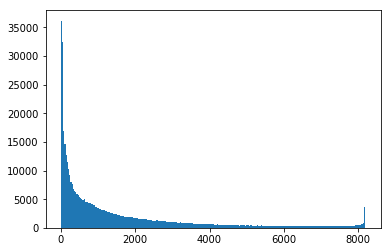

In [93]:
plt.hist(np.ndarray.flatten(motCorr_brain_out[:,:,:,0]),bins=256);
plt.show()

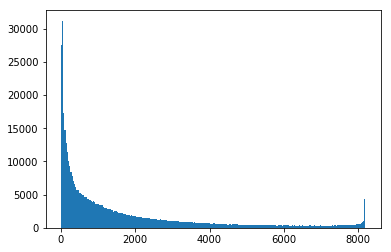

In [94]:
plt.hist(np.ndarray.flatten(motCorr_brain_out[:,:,:,162]),bins=256);
plt.show()

In [96]:
brain_thresh_all = np.asarray(brain_thresh_all)

In [97]:
brain_thresh_all.shape

(200, 128, 73, 49)

In [98]:
brain_thresh_all = np.moveaxis(brain_thresh_all,0,-1)

In [99]:
brain_thresh_all.shape

(128, 73, 49, 200)

In [100]:
save_file = os.path.join(root_path, fly_folders[0], 'thresh_500.nii')
#brain_to_save = np.swapaxes(brain_clipped, 0, 2)
ants.image_write(ants.from_numpy(brain_thresh_all), save_file)

In [40]:
brain_test = scipy.ndimage.filters.gaussian_filter(brain[:,:,:,0], sigma=1)

In [41]:
thresh = skimage.filters.threshold_triangle(brain_test, nbins=256)

In [52]:
brain_thresh = np.copy(brain_test)

In [53]:
brain_thresh[brain_thresh < thresh] = 0

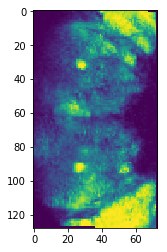

In [80]:
plt.imshow(motCorr_brain_out[:,:,20,0])
plt.show()

In [72]:
brain_thresh_small = rescale_brain(brain_thresh, 4)

In [73]:
x,y,z,filled,facecolors = plot_cube(brain_thresh_small)

In [76]:
brain_thresh_small.shape

(32, 18, 12)

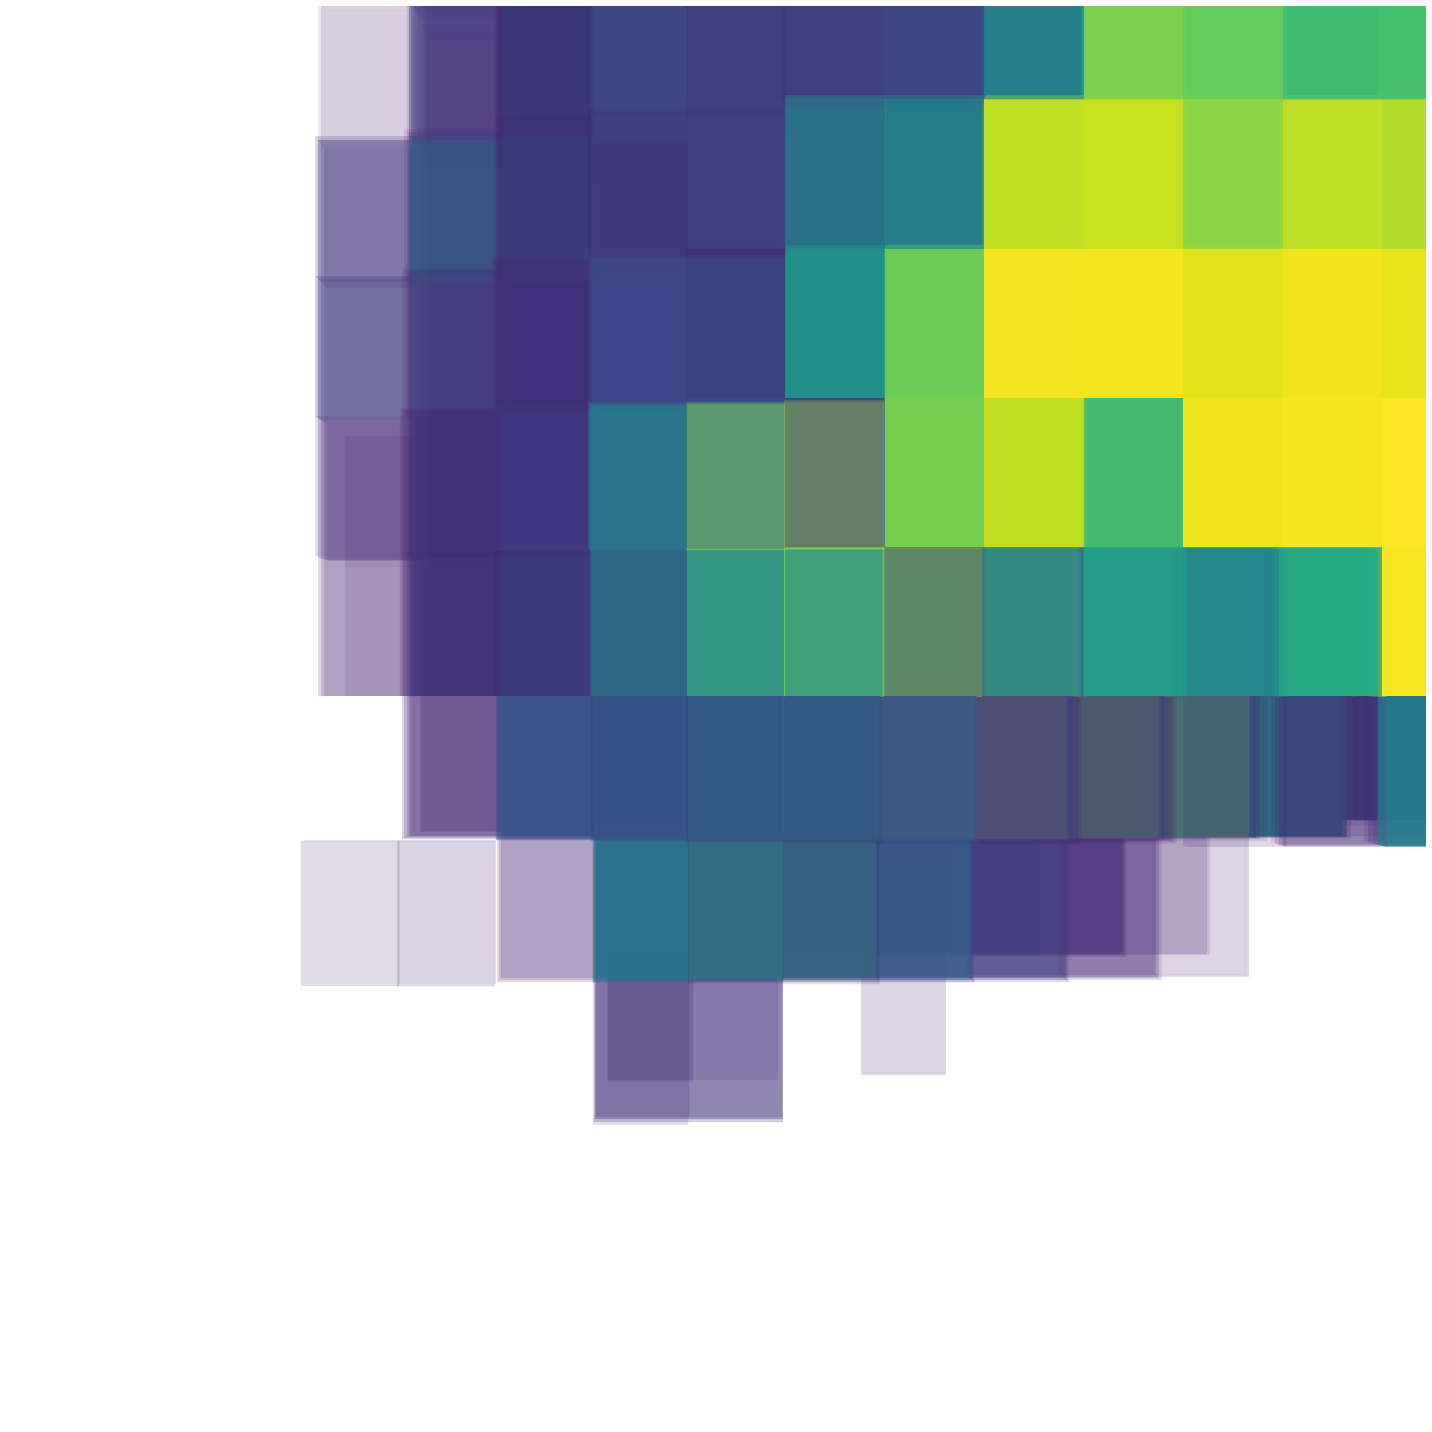

In [77]:
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')

ax.voxels(x, y, z, filled, facecolors=facecolors)
ax.view_init(0, 0)

set_axes_equal(ax) 
ax.set_xlim(0, 32)
ax.set_ylim(0, 18)
ax.set_zlim(0, 12)
ax._axis3don = False
plt.tight_layout()

plt.show()

In [70]:
brain_thresh.shape

(128, 73, 49)

##### Lets make a movie of the first 10 volumes

In [18]:
t0 = time()
surface_mean = make_brain_surface(meanbrain, thresh=None, sigma=1, scale=2)
movie_folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/movie_moving'
for i in range(200):
    surface_vol = make_brain_surface(brain[:,:,:,i], thresh=None, sigma=1, scale=2)
    surfaces = [surface_mean, surface_vol]
    plot_surfaces(surfaces, elev=0, azim=90, save=True, frame=i, folder=movie_folder)
print(time()-t0)

0
1
2
3
4


/home/users/brezovec/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
1036.2442424297333


##### Nice! Next, lets align the first 100 frames

In [19]:
#load affine transform file
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_15/motcorr_params.npy'
motcorr_params = np.load(file)
for i in range(200):
    ants.apply_transform(motcorr_params[i,:])


In [48]:
brain_out = []
for i in range(200):
    print(i)
    brain_vol = ants.from_numpy(brain[:,:,:,i])
    brain_out.append(ants.apply_transforms(moving=brain_vol, fixed=meanbrain_ants, transformlist=transforms[i][1]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [54]:
brain_out = []
for i in range(200):
    print(i)
    brain_vol = ants.from_numpy(brain[:,:,:,i])
    brain_out.append(ants.apply_transforms(moving=brain_vol, fixed=meanbrain_ants, transformlist=transforms[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [57]:
help(ants.apply_transforms)

Help on function apply_transforms in module ants.registration.apply_transforms:

apply_transforms(fixed, moving, transformlist, interpolator='linear', imagetype=0, whichtoinvert=None, compose=None, verbose=False, **kwargs)
    Apply a transform list to map an image from one domain to another.
    In image registration, one computes mappings between (usually) pairs
    of images. These transforms are often a sequence of increasingly
    complex maps, e.g. from translation, to rigid, to affine to deformation.
    The list of such transforms is passed to this function to interpolate one
    image domain into the next image domain, as below. The order matters
    strongly and the user is advised to familiarize with the standards
    established in examples.
    
    ANTsR function: `antsApplyTransforms`
    
    Arguments
    ---------
    fixed : ANTsImage
        fixed image defining domain into which the moving image is transformed.
    
    moving : AntsImage
        moving image to be

In [59]:
transforms[0]

['/tmp/tmp46s6s1x61Warp.nii.gz', '/tmp/tmp46s6s1x60GenericAffine.mat']

In [87]:
surface_mean = make_brain_surface(meanbrain, thresh=None, sigma=1, scale=2)

In [150]:
surface_vol = make_brain_surface(brain[:,:,:,3000], thresh=None, sigma=1, scale=2)

In [151]:
surfaces = [surface_mean, surface_vol]

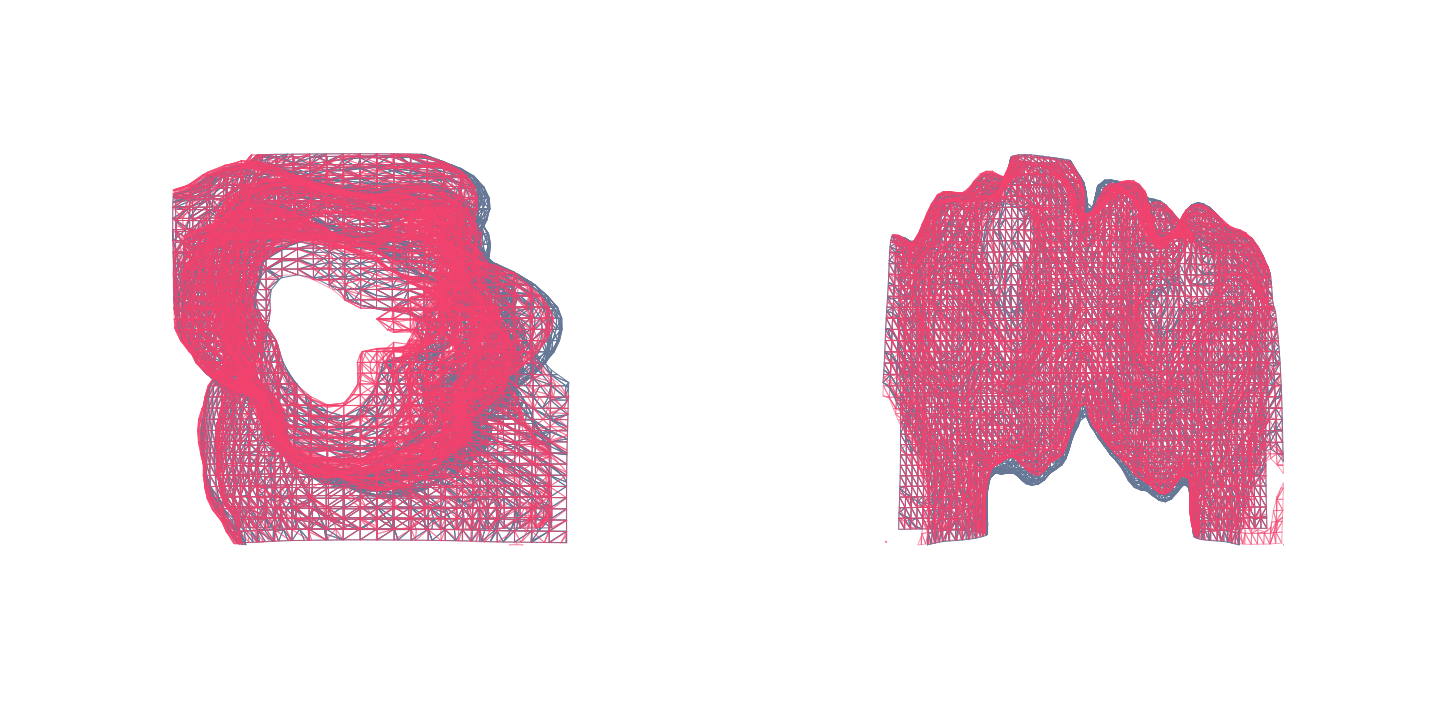

In [197]:
plot_dual_surfaces(surfaces)